# Descriptors and ML

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = [20, 10]

## PASCAL VOC

Homepage: http://host.robots.ox.ac.uk/pascal/VOC/index.html

Download the training and validation data from the PASCAL VOC 2012.



In [22]:
PATH_DATASET = "C:/Users/ca01770/Documents/GitHub/Computer-vision-and-3D-reconstruction/04-DescriptorsML/VOC2012/"

In [23]:
file_person_images = PATH_DATASET + "ImageSets/Main/person_train.txt"
with open(file_person_images) as file:
    lines = file.readlines()
    list_person_images = [line.rstrip().split()[0] for line in lines if line.rstrip().split()[1] == "1"] # 

In [24]:
list_person_images[:5]

['2008_000008', '2008_000023', '2008_000036', '2008_000041', '2008_000096']

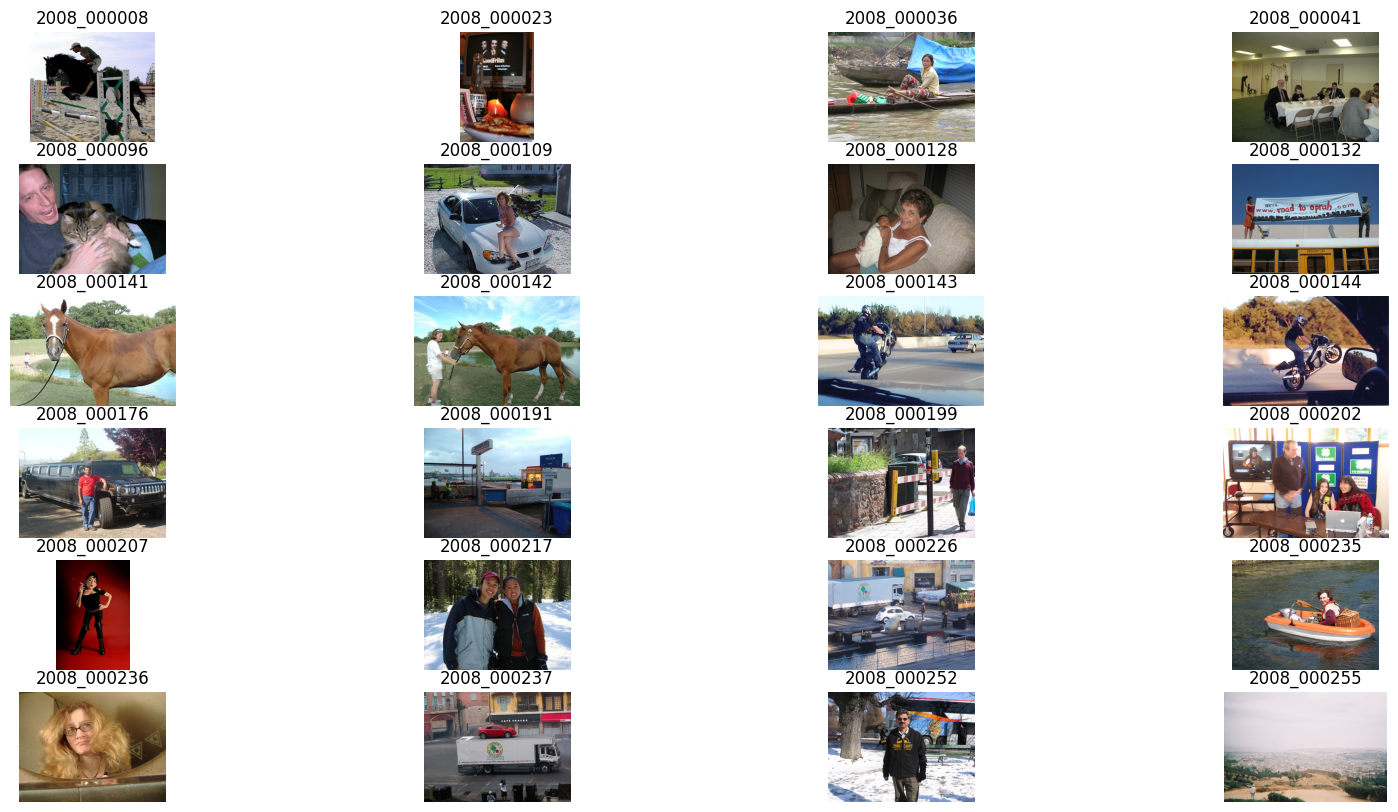

In [25]:
fig, axes = plt.subplots(6, 4)
axes = axes.flatten()
for i in range(len(axes)):
    image_name = list_person_images[i]
    path_image = PATH_DATASET + "JPEGImages/" + image_name + ".jpg"
    image = cv2.imread(path_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].set_title(image_name)
    axes[i].imshow(image)
    axes[i].axis('off')

In [26]:
import xml.etree.ElementTree as ET

def find_image_annotations(image_name, classname):
    path_annotations = PATH_DATASET + "Annotations/" + image_name + ".xml"
    annotations = []
    tree = ET.parse(path_annotations)
    root = tree.getroot()
    for item in root.findall("object[name='" + classname + "']"):
        xmin = int(item.find('bndbox/xmin').text)
        xmax = int(item.find('bndbox/xmax').text)
        ymin = int(item.find('bndbox/ymin').text)
        ymax = int(item.find('bndbox/ymax').text)
        annotations.append((xmin, xmax, ymin, ymax))
        
    return annotations

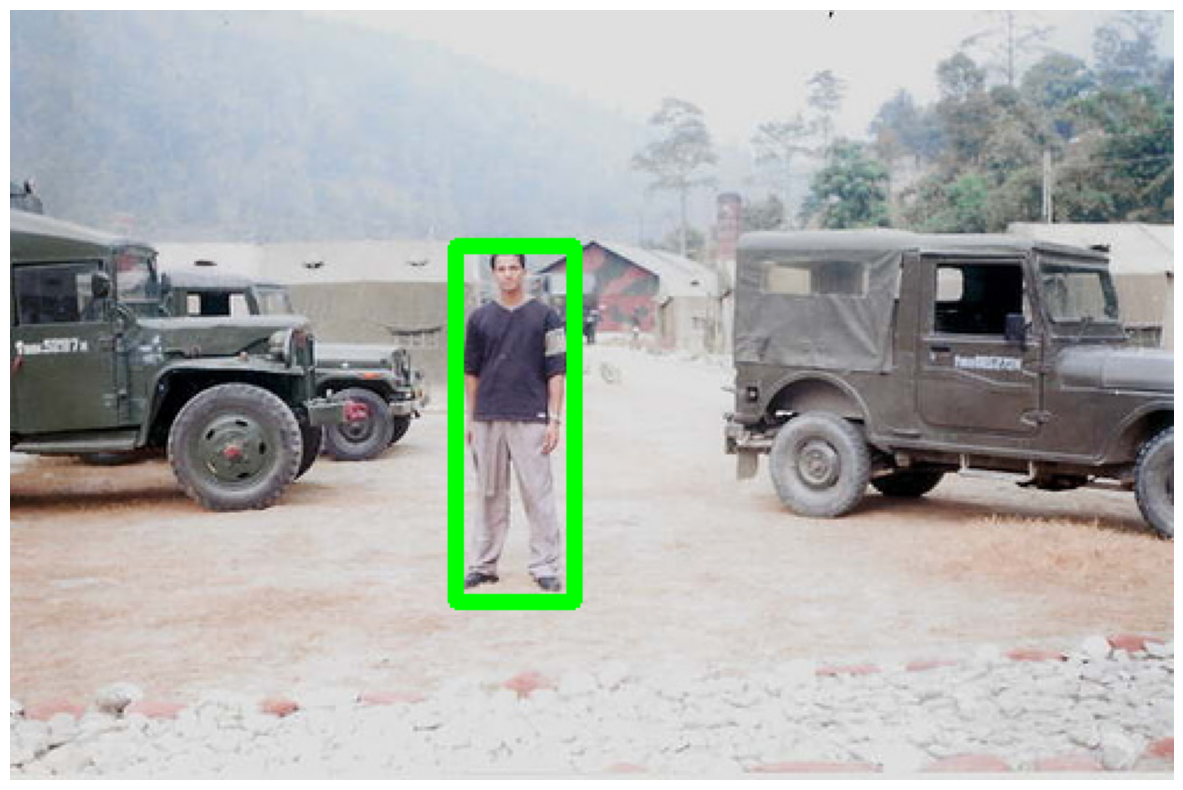

In [27]:
image_name = "2008_000260"
path_image = PATH_DATASET + "JPEGImages/" + image_name + ".jpg"

image = cv2.imread(path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
annotations = find_image_annotations(image_name, 'person')
im_drawed = image.copy()
for xmin, xmax, ymin, ymax in annotations:
    cv2.rectangle(im_drawed, (xmin, ymin), (xmax, ymax), (0, 255, 0), 5)
plt.imshow(im_drawed)
plt.axis('off');

## Pedestrian detector

The code from the next example come from: https://pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/. 
In this we are using a pre-trained SVM to detect pedestrians in images.

Method documentation: https://docs.opencv.org/4.5.3/d5/d33/structcv_1_1HOGDescriptor.html

In [28]:
# Agafam es bounding box que millor encaixa l'obectiu
# pip install imutils
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [29]:
hog = cv2.HOGDescriptor() #Cream un HOG descriptor model
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) # Pre-trained super vector machine model for people detection

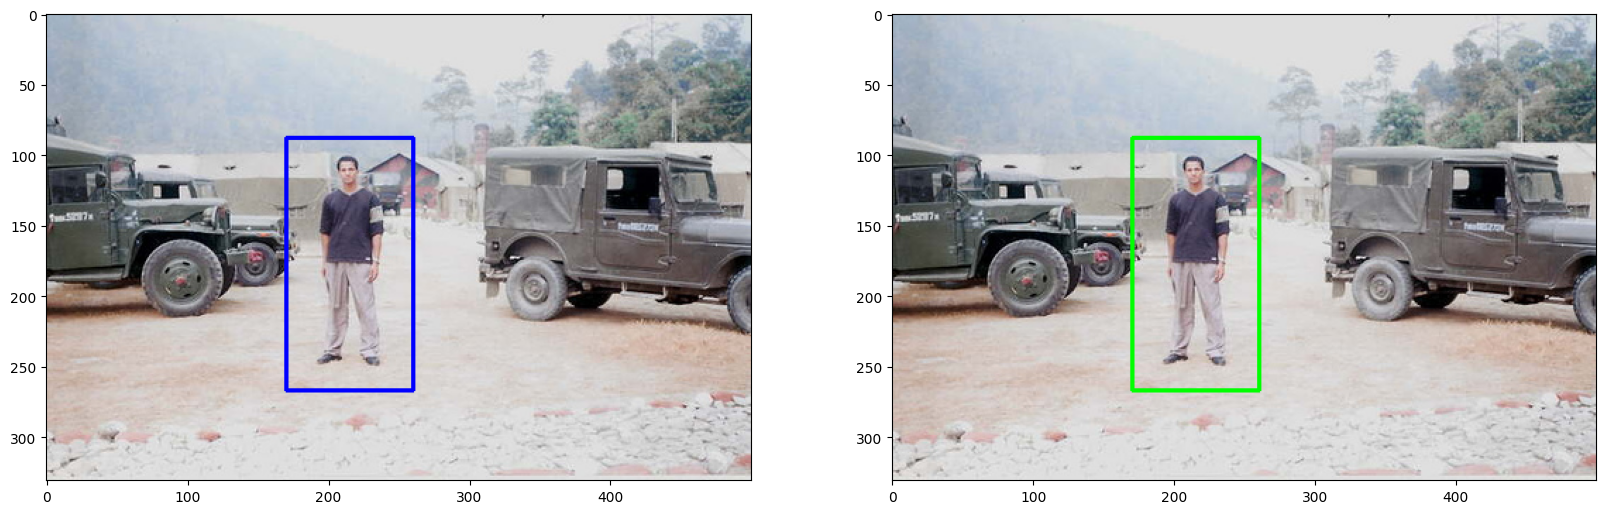

In [30]:
orig = image.copy()

# detect people in the image
(rects, weights) = hog.detectMultiScale(image, winStride=(4, 4), # Multiscale (Viola-Jones) en todas las square, miramos todos los square que encajen el objetivo, porque puede haber squares que sean mas pequeños que nuestro objetivo
                                        padding=(8, 8), scale=1.05)
 
# draw the original bounding boxes
for (x, y, w, h) in rects:
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)

# apply non-maxima suppression to the bounding boxes using a
# fairly large overlap threshold to try to maintain overlapping
# boxes that are still people
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)
 
# draw the final bounding boxes
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

fig, axes = plt.subplots(1, 2)    
axes[0].imshow(orig)
axes[1].imshow(image);

## Tasks

* Define a metric to evaluate the prections quality (Next repository has an explaination of the most used ones on object detection: https://github.com/rafaelpadilla/Object-Detection-Metrics).
* Evaluate the obtained results on the whole dataset with this metric.
* Observe how the results vary changing the algorithm parameters (inspect the images with the predictions and compare the evaluation metrics)


**For the aim to accelerate the task you can limit the dataset images to 100**

In [31]:
!mkdir output

Ya existe el subdirectorio o el archivo output.


In [32]:
#!pip install imutils

In [33]:
import metrics
#import imutils

In [34]:
def prueba(tp, tn, fp, fn, p, n, threshold):
    for image_name in list_person_images[:100]:
        path_image = PATH_DATASET + "JPEGImages" + os.path.sep + image_name + ".jpg"
        image = cv2.imread(path_image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        orig = image.copy()

        annotations = find_image_annotations(image_name, "person")
        
        # draw labels
        for (xmin, xmax, ymin, ymax) in annotations:
            cv2.rectangle(orig, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)

        # detect people in the image
        (rects, weights) = hog.detectMultiScale(image, winStride=(4, 4),
                                                padding=(4, 4), scale=1.05)

        # draw the original bounding boxes
        for (x, y, w, h) in rects:
            cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 1)

        # apply non-maxima suppression to the bounding boxes using a
        # fairly large overlap threshold to try to maintain overlapping
        # boxes that are still people
        rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
        detections = non_max_suppression(rects, probs=None, overlapThresh=0.65)

        # draw the final bounding boxes
        for (xA, yA, xB, yB) in detections:
            cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

        tp_im, fp_im = 0, 0
        for (xA, yA, xB, yB) in detections:
            max_iou = 0
            for (xmin, xmax, ymin, ymax) in annotations:
                iou = metrics.IoU_bounding_box((xA, yA, xB-xA, yB-yA), (xmin, ymin, xmax-xmin, ymax-ymin))
                if iou > max_iou:
                    max_iou=iou
            if max_iou >= threshold:
                tp_im += 1
            else:
                fp_im += 1
        fn_im = len(annotations) - tp_im   
        #if fn_im < 0:
        #    print("Impossible: Too small threshold")
        tp += tp_im
        fp += fp_im
        fn += fn_im
        p += len(annotations)

        fig, axes = plt.subplots(1, 2)    
        axes[0].set_title("Labels + initial detections")
        axes[0].imshow(orig)
        axes[1].set_title("Final detections")
        axes[1].imshow(image);
        plt.savefig("output" + os.path.sep + image_name + ".jpg", bbox_inches='tight')
        fig.clear()
        plt.close(fig)
    #assert tp + fn == p
    return threshold, p, n, tp, tn, fp, fn


## Metric explanation

In [35]:
tp, tn, fp, fn = 0, 0, 0, 0
p, n = 0, 0
threshold = 0
print(f"Threshold | Recall")
while threshold < 0.9:
    threshold += 0.1
    threshold, p, n, tp, tn, fp, fn = prueba(tp, tn, fp, fn, p, n, threshold)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{round(threshold,1)} | {round(recall,2)} |")
    

Threshold | Recall


0.1 | 0.28 |
0.2 | 0.24 |
0.3 | 0.21 |
0.4 | 0.19 |
0.5 | 0.17 |
0.6 | 0.14 |
0.7 | 0.12 |
0.8 | 0.11 |
0.9 | 0.1 |
1.0 | 0.09 |


## Recall explanation

The recall is a metric used to evaluate the performance of a classification model, representing the proportion of actual positive cases that the model correctly identifies. It is calculated as the number of true positives divided by the sum of true positives and false negatives: `tp / (tp + fn)`.

This decrease in recall with an increasing threshold is due to the model becoming more selective about what it classifies as a positive. As the threshold rises, the model requires a higher level of confidence for a prediction to be considered positive. Consequently, some true positives can be lost because thus can't surpass this heightened threshold and thus are not detected, leading to a lower recall. Essentially, a higher threshold can cause the model to miss more actual positive instances, resulting in a reduction of recall.

# -- BONUS CONTENT --

## Machine learning

Split the dataset in training, validation and test sets.

As the dataset is composed by 11530 images, we can define the three sets with the next proportions:
* 60\% training
* 20\% validation
* 20\% test

A training set of 6918 images will be more than enough for our concrete case. In spite of, you are free to modify the subsets proportions, another good partition would be 80/10/10.

In [36]:
#from skimage.feature import hog
from sklearn.model_selection import train_test_split
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

base_dir = 'C:/Users/ca01770/Documents/GitHub/Computer-vision-and-3D-reconstruction/04-DescriptorsML/VOC2012/JPEGImages'

# Get all image paths
image_paths = glob.glob(os.path.join(base_dir, '*.jpg'))
image_paths = np.array(image_paths)

# Split into training and temp set (temp will be further split into validation and test)
train_paths, temp_paths = train_test_split(image_paths, test_size=0.40, random_state=42)

# Splitting the temp set into validation and test sets
val_paths, test_paths = train_test_split(temp_paths, test_size=0.50, random_state=42)


Feature extraction process

In [37]:
from skimage.feature import hog
from skimage import io

# Example of processing a single image
image = io.imread(train_paths[0])  # Load an image from the training set
print(f"Antes: {image.ndim}")
image_2d = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
print(f"Despues: {image_2d.ndim}")


Antes: 3
Despues: 2


In [38]:
hog_features, hog_image = hog(image_2d, visualize=True)

## Format the images to train the model

To train a machine learing model you should transform the data to the required format by the selected algorithm implementation. You should format the training data in a bidimensional matrix, which one axis represent the training samples and the other axis the features.

In this subject we will use the machine learning algorithms provided by scikit-learn library. That library follows a standard data format for all algorithms, where the rows of the input matrix represents the training samples and the columns, the features. So, if we have $M$ training samples and $N$ features, the input matrix will have a shape: $X \in M \times N$

On the other hand, this algorithms also need the input of the dataset labels, which will have a concrete format. In the current problem the labels will have 4 values ($x_{min}$, $x_{max}$, $y_{min}$ and $y_{max}$), in the algorithm implementation that we use we will introduce this labels with the next format: $Y \in M \times 4$.

Next code show you how to format the data:

In [39]:
import numpy as np
import cv2
from skimage.feature import hog

n_features = (int(512/8) ** 2) * 9
m = len(list_person_images)
X = np.zeros((m, n_features))

i = 0
for image_name in list_person_images:
    path_image = PATH_DATASET + "JPEGImages/" + image_name + ".jpg"
    image = cv2.imread(path_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    fd = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    feature_vector=True,
                    cells_per_block=(1, 1), visualize=False)
    
    X[i, :] = fd
    i += 1


Recommended read: https://www.pyimagesearch.com/2021/01/20/opencv-resize-image-cv2-resize/